# Handling Shocks (Xử lý cú sốc)

Do hậu quả của việc đóng cửa do đại dịch COVID-19 gây ra, nhiều chuỗi thời gian đã trải qua “cú sốc” trong năm 2020, ví dụ: mức tiêu thụ phương tiện truyền thông (Netflix, YouTube), giao dịch thương mại điện tử (Amazon, eBay) tăng đột biến, trong khi việc tham dự các sự kiện trực tiếp giảm đáng kể.

Hầu hết các chuỗi thời gian này cũng sẽ duy trì cấp độ mới trong một khoảng thời gian, tùy thuộc vào những biến động do nới lỏng phong tỏa và/hoặc vắc-xin.

Các mô hình theo mùa cũng có thể đã thay đổi: ví dụ: mọi người có thể đã sử dụng ít phương tiện hơn (tính theo tổng số giờ) vào các ngày trong tuần so với các ngày cuối tuần trước khi có lệnh phong tỏa do COVID, nhưng trong thời gian phong tỏa, mức tiêu thụ vào các ngày trong tuần có thể gần hơn nhiều so với mức tiêu thụ vào cuối tuần.

Trong trang này, chúng ta sẽ khám phá một số chiến lược để nắm bắt các hiệu ứng này bằng chức năng của Prophet:

1. Đánh dấu các thay đổi/tăng đột biến số bước do các sự kiện COVID là một lần.
2. Những thay đổi liên tục trong hành vi dẫn đến những thay đổi về xu hướng và tính thời vụ.

## Case Study - Pedestrian Activity (Nghiên cứu điển hình - Hoạt động của người đi bộ)

Đối với nghiên cứu điển hình này, chúng tôi sẽ sử dụng [dữ liệu Cảm biến người đi bộ từ Thành phố Melbourne](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-Monthly-counts-per-hour/b2ak-trbp). Dữ liệu này đo lưu lượng người qua lại từ các cảm biến ở nhiều nơi khác nhau trong khu thương mại trung tâm và chúng tôi đã chọn một cảm biến (Sensor_ID = 4) và tổng hợp các giá trị thành hạt hàng ngày.

Tập dữ liệu tổng hợp có thể được tìm thấy trong thư mục ví dụ [tại đây](https://github.com/facebook/prophet/tree/master/examples/example_pedestrians_covid.csv).


<Axes: xlabel='ds'>

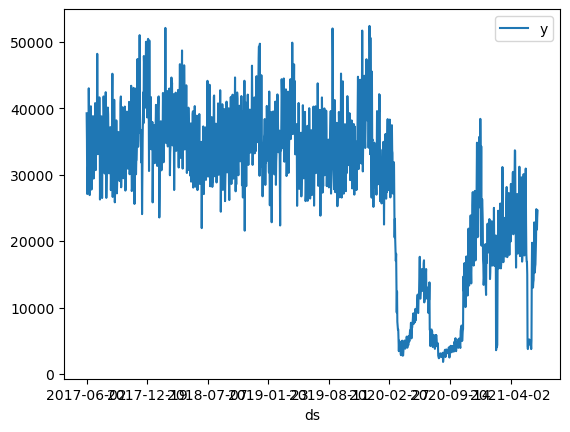

In [5]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_pedestrians_covid.csv')
df.set_index('ds').plot()

Chúng ta có thể thấy hai sự kiện quan trọng trong chuỗi thời gian:

- Lượng người đi bộ ban đầu giảm vào khoảng ngày 21 tháng 3 năm 2020, sau đó bắt đầu phục hồi vào khoảng ngày 6 tháng 6 năm 2020. Điều này tương ứng với tuyên bố về đại dịch của WHO và các lệnh phong tỏa sau đó do chính phủ Victoria yêu cầu.
- Sau một thời gian phục hồi chậm, lượng người đi bộ giảm lần thứ hai vào khoảng ngày 9 tháng 7 năm 2020, bắt đầu phục hồi vào khoảng ngày 27 tháng 10 năm 2020. Điều này tương ứng với “làn sóng thứ hai” của đại dịch ở vùng đô thị Melbourne.

Ngoài ra còn có các khoảng thời gian phong tỏa nghiêm ngặt ngắn hơn dẫn đến các mẹo đột ngột trong chuỗi thời gian: 5 ngày vào tháng 2 năm 2021 và 14 ngày vào đầu tháng 6 năm 2021.

## Default model without any adjustments (Mô hình mặc định mà không có bất kỳ điều chỉnh nào)

Trước tiên, chúng tôi sẽ điều chỉnh một mô hình với cài đặt Tiên tri mặc định:

In [6]:
m = Prophet()
m = m.fit(df)
future = m.make_future_dataframe(periods=366)
forecast = m.predict(future)

21:00:01 - cmdstanpy - INFO - Chain [1] start processing
21:00:02 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'Default Prophet')

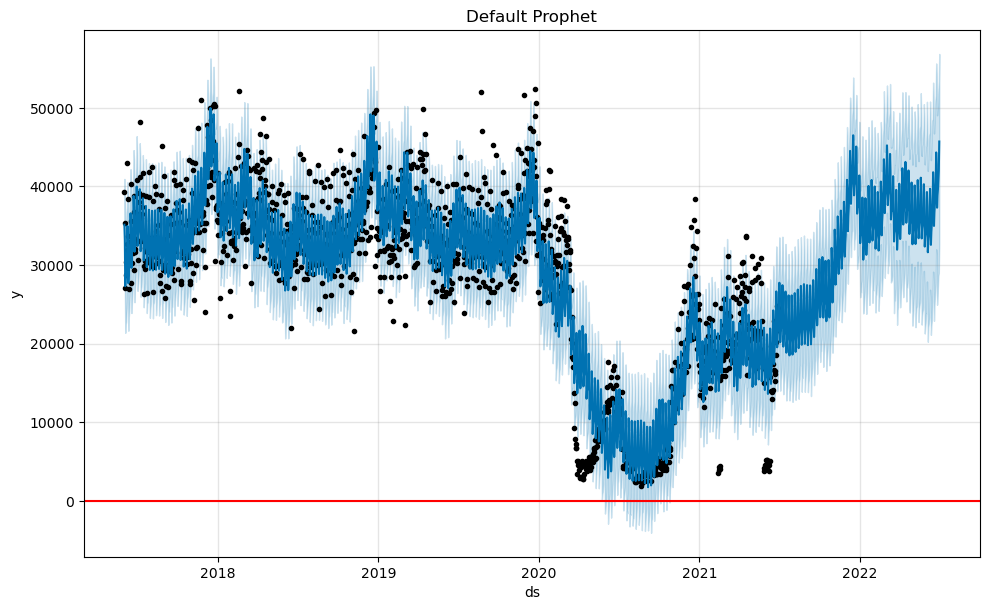

In [8]:
m.plot(forecast)
plt.axhline(y=0, color='red')
plt.title('Default Prophet')

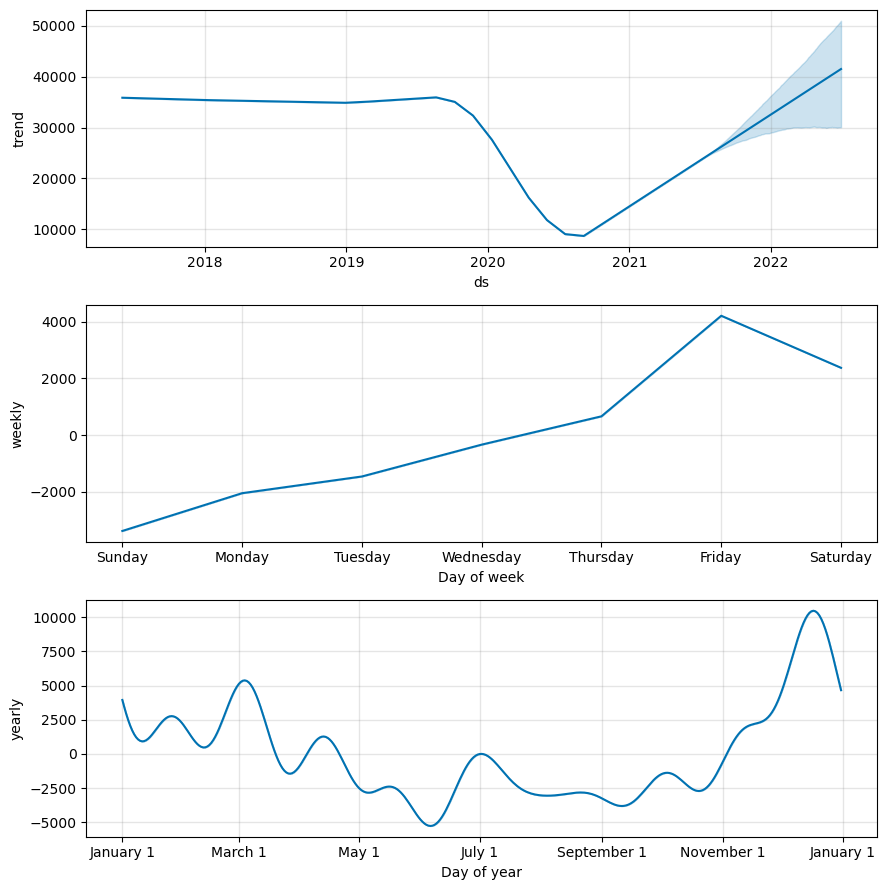

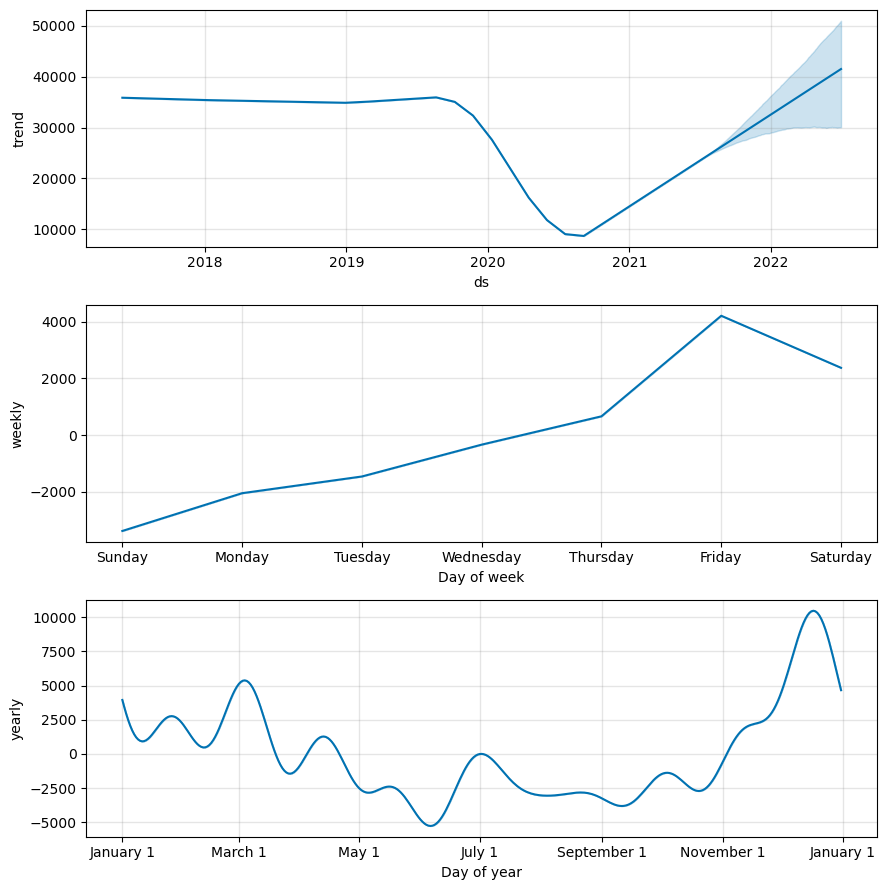

In [9]:
m.plot_components(forecast)

Mô hình này có vẻ phù hợp một cách hợp lý với dữ liệu trong quá khứ, nhưng hãy lưu ý cách chúng tôi nắm bắt các mức giảm và mức tăng đột biến sau các mức giảm, như một phần của thành phần xu hướng.

Theo mặc định, mô hình giả định rằng những đột biến lớn này có thể xảy ra trong tương lai, mặc dù trên thực tế chúng ta sẽ không thấy điều gì đó có cùng cường độ trong khoảng thời gian dự báo của mình (trong trường hợp này là 1 năm). Điều này dẫn đến một dự báo khá lạc quan về sự phục hồi của lưu lượng người đi bộ vào năm 2022.

## Treating COVID-19 lockdowns as a one-off holidays (Coi việc lockdown COVID-19 như một kỳ nghỉ một lần)

Để ngăn các đợt giảm giá lớn và tăng đột biến do thành phần xu hướng nắm bắt, chúng ta có thể coi những ngày bị ảnh hưởng bởi COVID-19 là những ngày nghỉ lễ sẽ không lặp lại trong tương lai. Việc thêm các ngày lễ tùy chỉnh được giải thích chi tiết hơn [tại đây](https://facebook.github.io/prophet/docs/handling_shocks.html). Chúng tôi đã thiết lập dataframe như vậy để mô tả các khoảng thời gian bị ảnh hưởng bởi lockdowns:

In [10]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13


- Chúng tôi có một mục nhập cho mỗi khoảng thời gian lockdown, với `ds` chỉ định thời điểm bắt đầu lockdown. `ds_upper` không được Prophet sử dụng, nhưng đó là cách thuận tiện để chúng tôi tính toán `upper_window`.
- `upper_window` nói với Prophet rằng thời gian lockdown kéo dài x ngày sau khi bắt đầu lockdown. Lưu ý rằng hồi quy ngày lễ bao gồm giới hạn trên.

Lưu ý rằng vì chúng tôi không chỉ định bất kỳ ngày nào trong tương lai, nên Prophet sẽ cho rằng những ngày lễ này sẽ không xảy ra nữa khi tạo khung dữ liệu trong tương lai (và do đó chúng sẽ không ảnh hưởng đến các dự đoán của chúng tôi). Điều này khác với cách chúng tôi chỉ định ngày nghỉ định kỳ.

In [11]:
m2 = Prophet(holidays=lockdowns)
m2 = m2.fit(df)
future2 = m2.make_future_dataframe(periods=366)
forecast2 = m2.predict(future2)

21:09:05 - cmdstanpy - INFO - Chain [1] start processing
21:09:07 - cmdstanpy - INFO - Chain [1] done processing


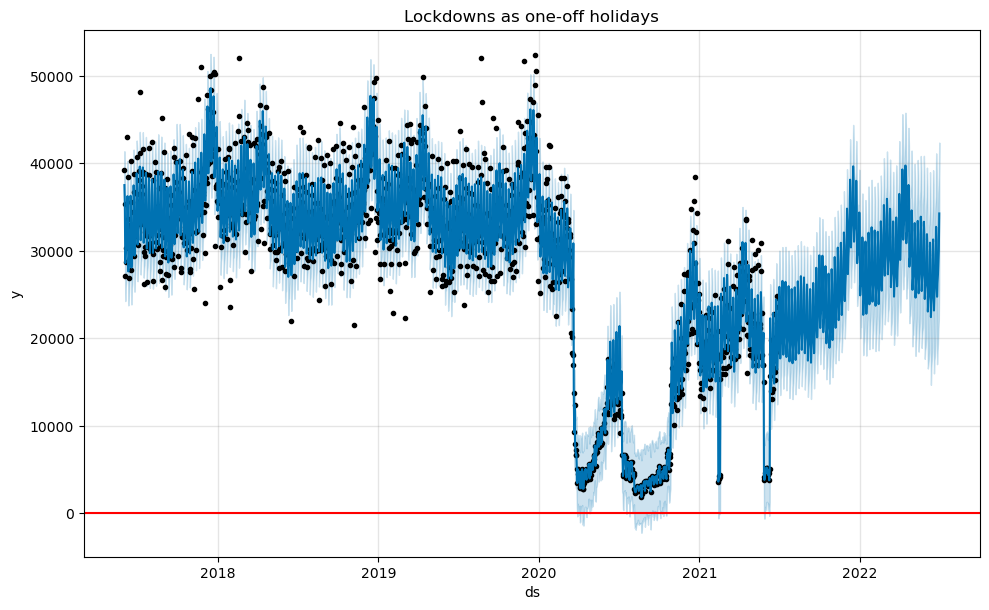

In [12]:
m2.plot(forecast2)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays');

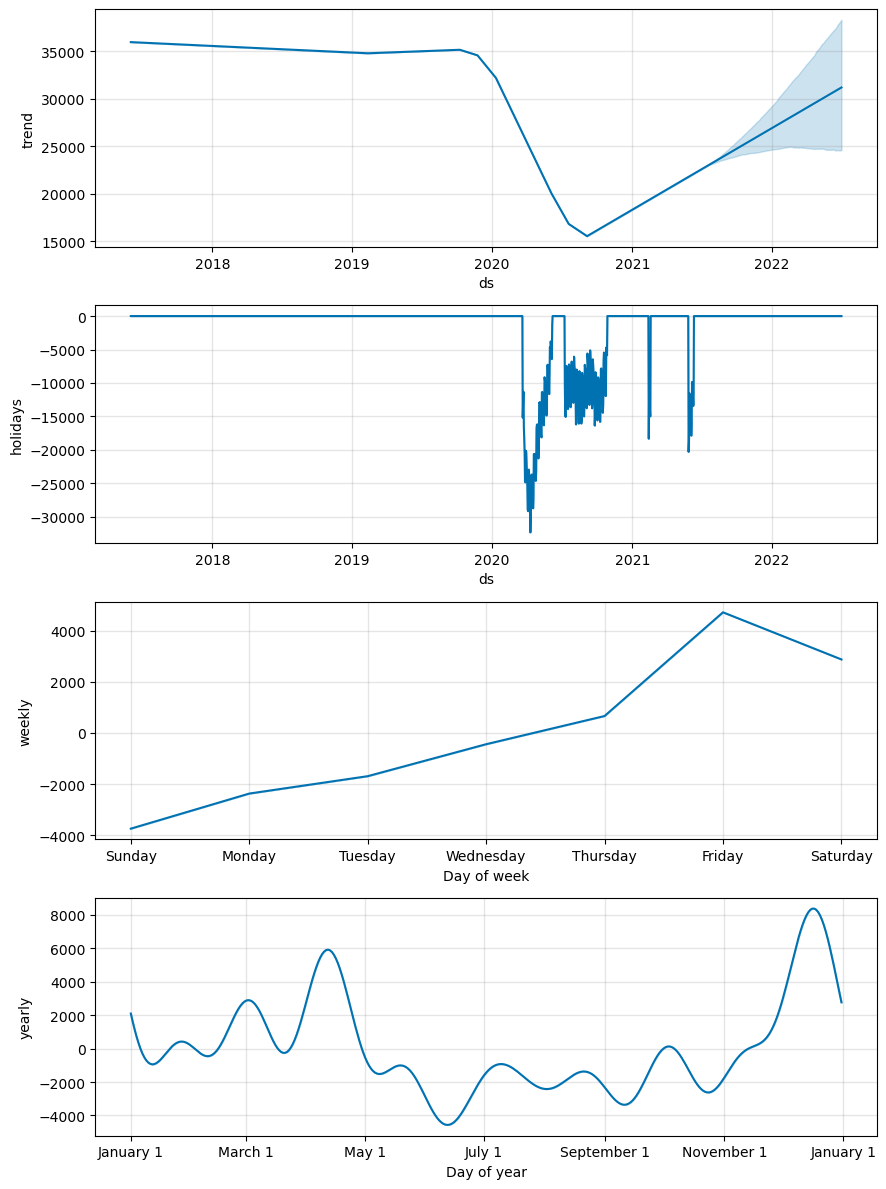

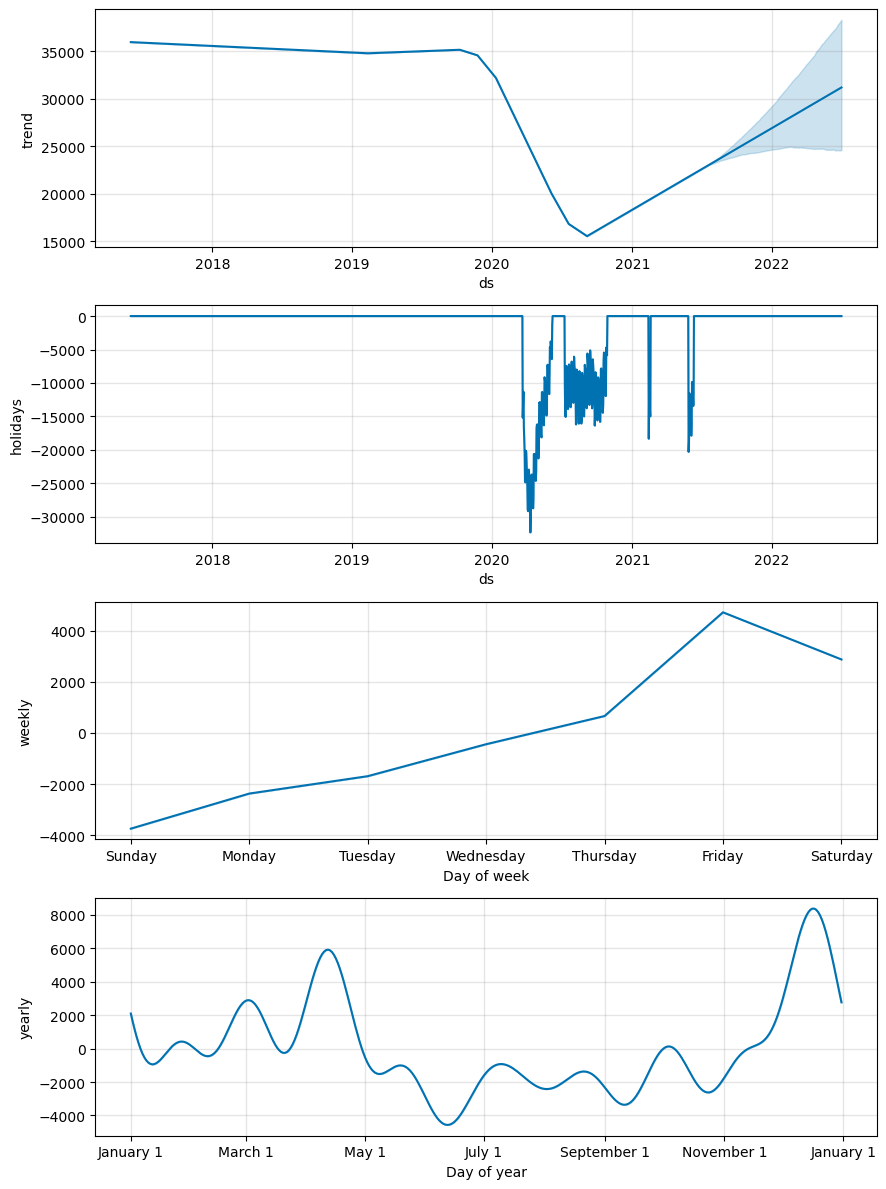

In [13]:
m2.plot_components(forecast2)

- Prophet đang gán một tác động tiêu cực lớn cho những ngày trong thời gian phong tỏa một cách hợp lý.
- Dự báo về xu hướng không mạnh mẽ/lạc quan và có vẻ khá hợp lý.

## Sense checking the trend (Hoàn cảnh kiểm tra xu hướng)

Trong một môi trường khi các hành vi liên tục thay đổi, điều quan trọng là phải đảm bảo rằng thành phần xu hướng của mô hình đang nắm bắt các mẫu mới nổi mà không overfitting với chúng.

Tài liệu về [trend changepoint](https://facebook.github.io/prophet/docs/trend_changepoints.html) giải thích hai điều chúng ta có thể điều chỉnh với thành phần xu hướng:
- Các vị trí điểm thay đổi, theo mặc định, cách đều nhau trên 80% lịch sử. Chúng ta nên lưu tâm đến nơi phạm vi này kết thúc và mở rộng phạm vi (bằng cách tăng % hoặc thêm các điểm thay đổi theo cách thủ công) nếu chúng ta tin rằng dữ liệu gần đây nhất phản ánh tốt hơn hành vi trong tương lai.
- Độ mạnh của quy tắc hóa (`changepoint_prior_scale`), xác định mức độ linh hoạt của xu hướng; giá trị mặc định là 0,05 và việc tăng giá trị này sẽ cho phép xu hướng phù hợp hơn với dữ liệu được quan sát.

Chúng tôi vẽ biểu đồ thành phần xu hướng và các điểm thay đổi được mô hình hiện tại của chúng tôi phát hiện bên dưới.

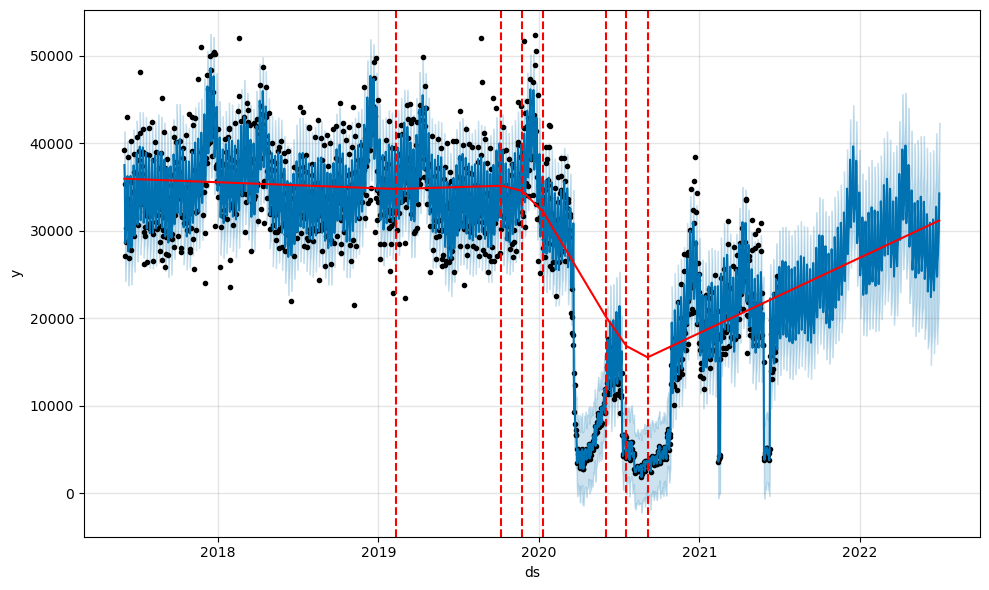

In [14]:
from prophet.plot import add_changepoints_to_plot
fig = m2.plot(forecast2)
a = add_changepoints_to_plot(fig.gca(), m2, forecast2)

Các điểm thay đổi được phát hiện có vẻ hợp lý và xu hướng tương lai theo dõi xu hướng tăng mới nhất trong hoạt động, nhưng không đến mức cuối năm 2020. Điều này có vẻ phù hợp để dự đoán chính xác nhất về hoạt động trong tương lai.

Chúng tôi có thể xem dự báo sẽ như thế nào nếu chúng tôi muốn nhấn mạnh hơn các mẫu COVID trong đào tạo mô hình; chúng ta có thể làm điều này bằng cách thêm nhiều điểm thay đổi tiềm năng sau năm 2020 và làm cho xu hướng trở nên linh hoạt hơn.

In [15]:
m3_changepoints = (
    # 10 potential changepoints in 2.5 years
    pd.date_range('2017-06-02', '2020-01-01', periods=10).date.tolist() +
    # 15 potential changepoints in 1 year 2 months
    pd.date_range('2020-02-01', '2021-04-01', periods=15).date.tolist()
)

In [16]:
# Default changepoint_prior_scale is 0.05, so 1.0 will lead to much more flexibility in comparison.
m3 = Prophet(holidays=lockdowns, changepoints=m3_changepoints, changepoint_prior_scale=1.0)
m3 = m3.fit(df)
forecast3 = m3.predict(future2)

21:20:29 - cmdstanpy - INFO - Chain [1] start processing
21:20:33 - cmdstanpy - INFO - Chain [1] done processing


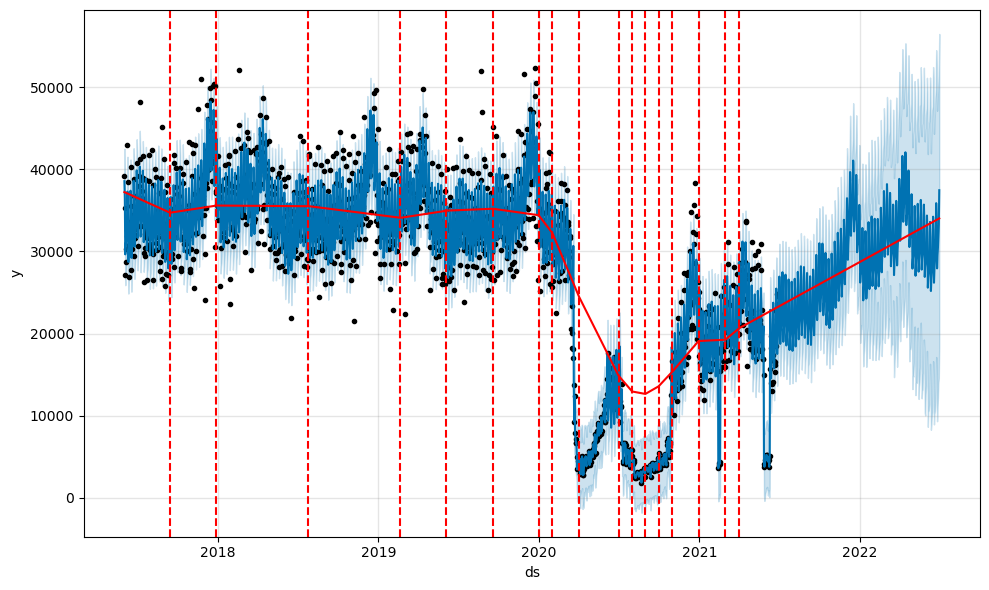

In [17]:
from prophet.plot import add_changepoints_to_plot
fig = m3.plot(forecast3)
a = add_changepoints_to_plot(fig.gca(), m3, forecast3)

Chúng tôi đang thấy nhiều điểm thay đổi được phát hiện sau COVID, phù hợp với các biến động khác nhau từ việc nới lỏng/siết chặt các biện pháp phong tỏa. Nhìn chung, đường cong xu hướng và xu hướng được dự báo khá giống với mô hình trước đây của chúng tôi, nhưng chúng tôi đang thấy nhiều sự không chắc chắn hơn do số lượng thay đổi xu hướng mà chúng tôi đã chọn trong lịch sử cao hơn.

Chúng tôi có thể sẽ không chọn mô hình này thay vì mô hình có tham số mặc định làm ước tính tốt nhất, nhưng đó là một minh chứng tốt về cách chúng tôi có thể kết hợp niềm tin của mình vào mô hình về những mẫu nào là quan trọng cần nắm bắt.

## Changes in seasonality between pre- and post-COVID (Thay đổi về tính thời vụ giữa trước và sau COVID)

Các biểu đồ thành phần theo mùa trong các phần trước cho thấy hoạt động cao nhất vào Thứ Sáu so với các ngày khác trong tuần. Nếu chúng tôi không chắc liệu điều này có còn tiếp tục sau khi phong tỏa hay không, thì chúng tôi có thể thêm các yếu tố thời vụ có điều kiện vào mô hình. Thời vụ có điều kiện được giải thích chi tiết hơn [ở đây](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#seasonalities-that-depend-on-other-factors).

Trước tiên, chúng tôi xác định các cột boolean trong khung dữ liệu lịch sử để gắn cờ các giai đoạn “trước covid” và “sau covid”:

In [18]:
df2 = df.copy()
df2['pre_covid'] = pd.to_datetime(df2['ds']) < pd.to_datetime('2020-03-21')
df2['post_covid'] = ~df2['pre_covid']

Tính thời vụ có điều kiện mà chúng tôi muốn lập mô hình ở đây là tính thời vụ theo ngày trong tuần (“hàng tuần”). Để thực hiện việc này, trước tiên chúng tôi tắt tính năng theo tuần mặc định khi chúng tôi tạo mô hình Prophet.

In [19]:
m4 = Prophet(holidays=lockdowns, weekly_seasonality=False)

Sau đó, chúng tôi thêm tính thời vụ hàng tuần này theo cách thủ công, dưới dạng hai thành phần mô hình khác nhau - một cho trước covid, một cho sau covid. Lưu ý rằng Fourier_order=3 là cài đặt mặc định cho thời vụ hàng tuần. Sau này, chúng ta có thể chạy .fit()

In [23]:
m4.add_seasonality(
    name='weekly_pre_covid',
    period=7,
    fourier_order=3,
    condition_name='pre_covid',
)
m4.add_seasonality(
    name='weekly_post_covid',
    period=7,
    fourier_order=3,
    condition_name='post_covid',
)

In [24]:
m4 = m4.fit(df2)

21:26:54 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] done processing


Chúng tôi cũng cần tạo các cờ pre_covid và post_covid trong khung dữ liệu tương lai. Điều này là để Prophet có thể áp dụng các tham số thời vụ hàng tuần chính xác cho mỗi ngày trong tương lai.

In [25]:
future4 = m4.make_future_dataframe(periods=366)
future4['pre_covid'] = pd.to_datetime(future4['ds']) < pd.to_datetime('2020-03-21')
future4['post_covid'] = ~future4['pre_covid']

In [26]:
forecast4 = m4.predict(future4)

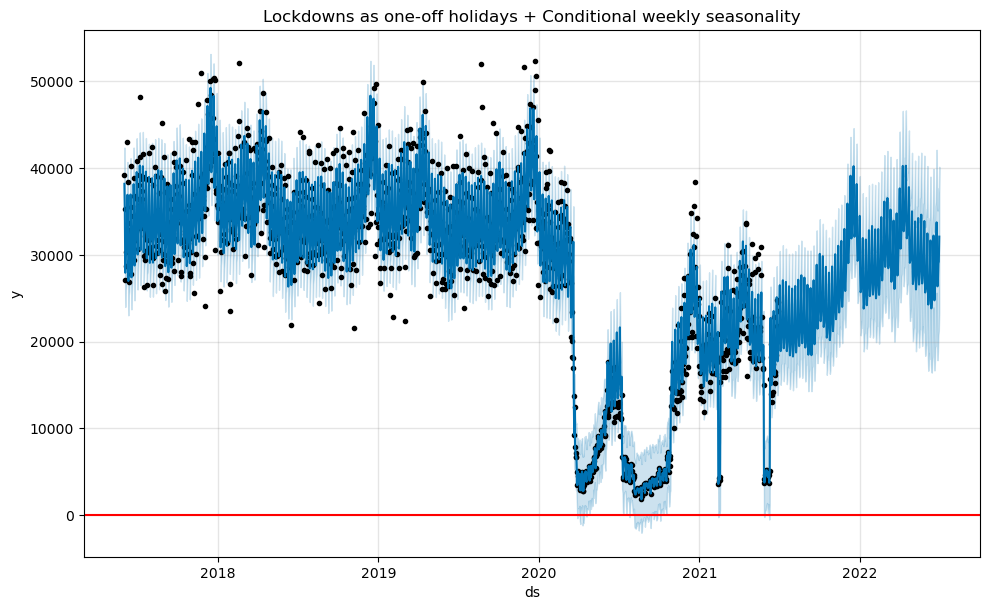

In [27]:
m4.plot(forecast4)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays + Conditional weekly seasonality');

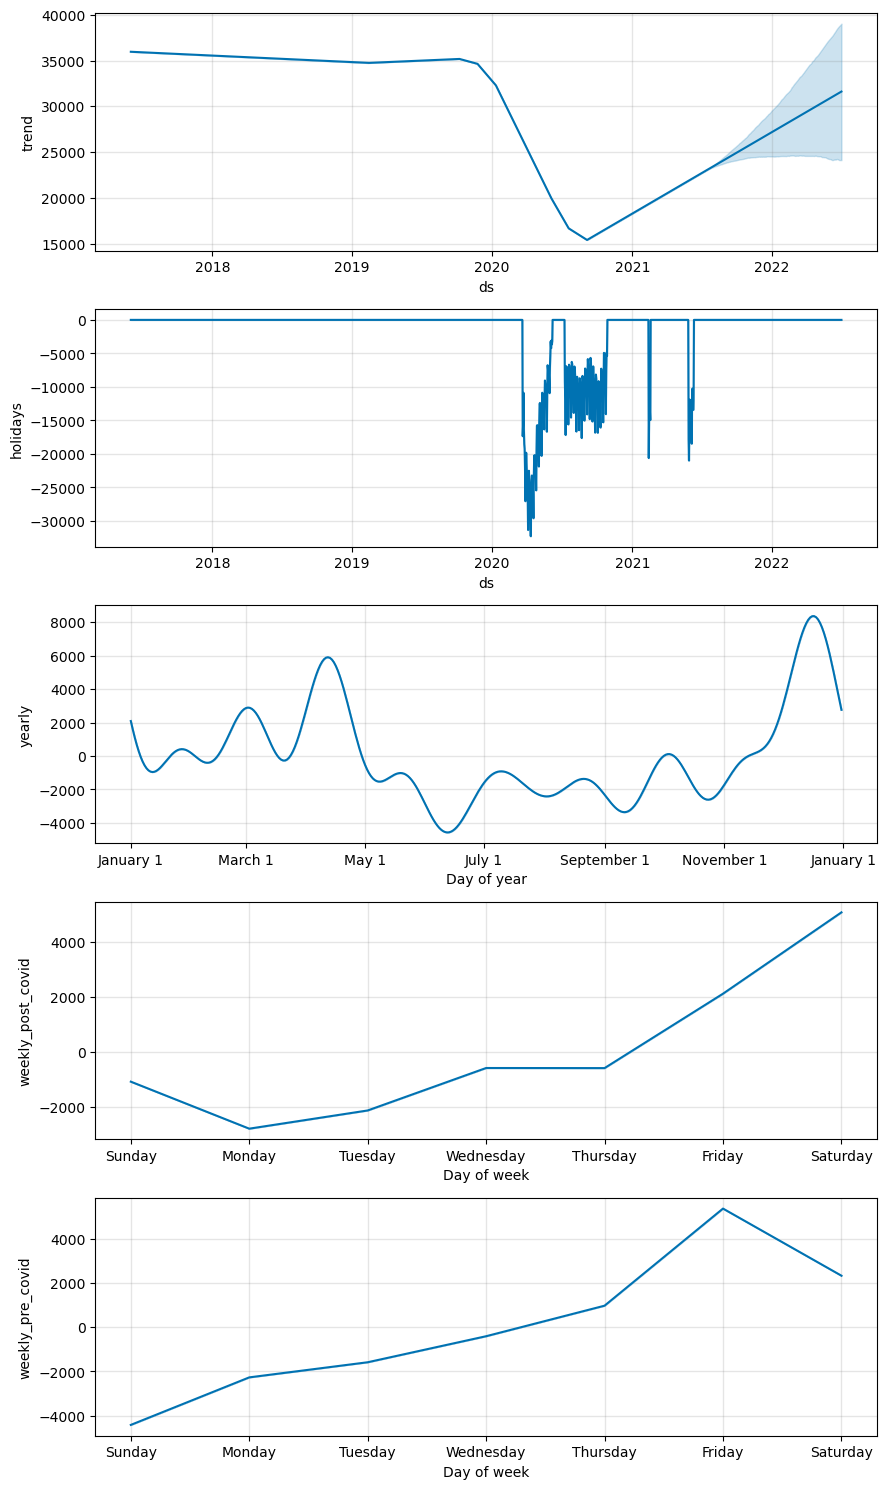

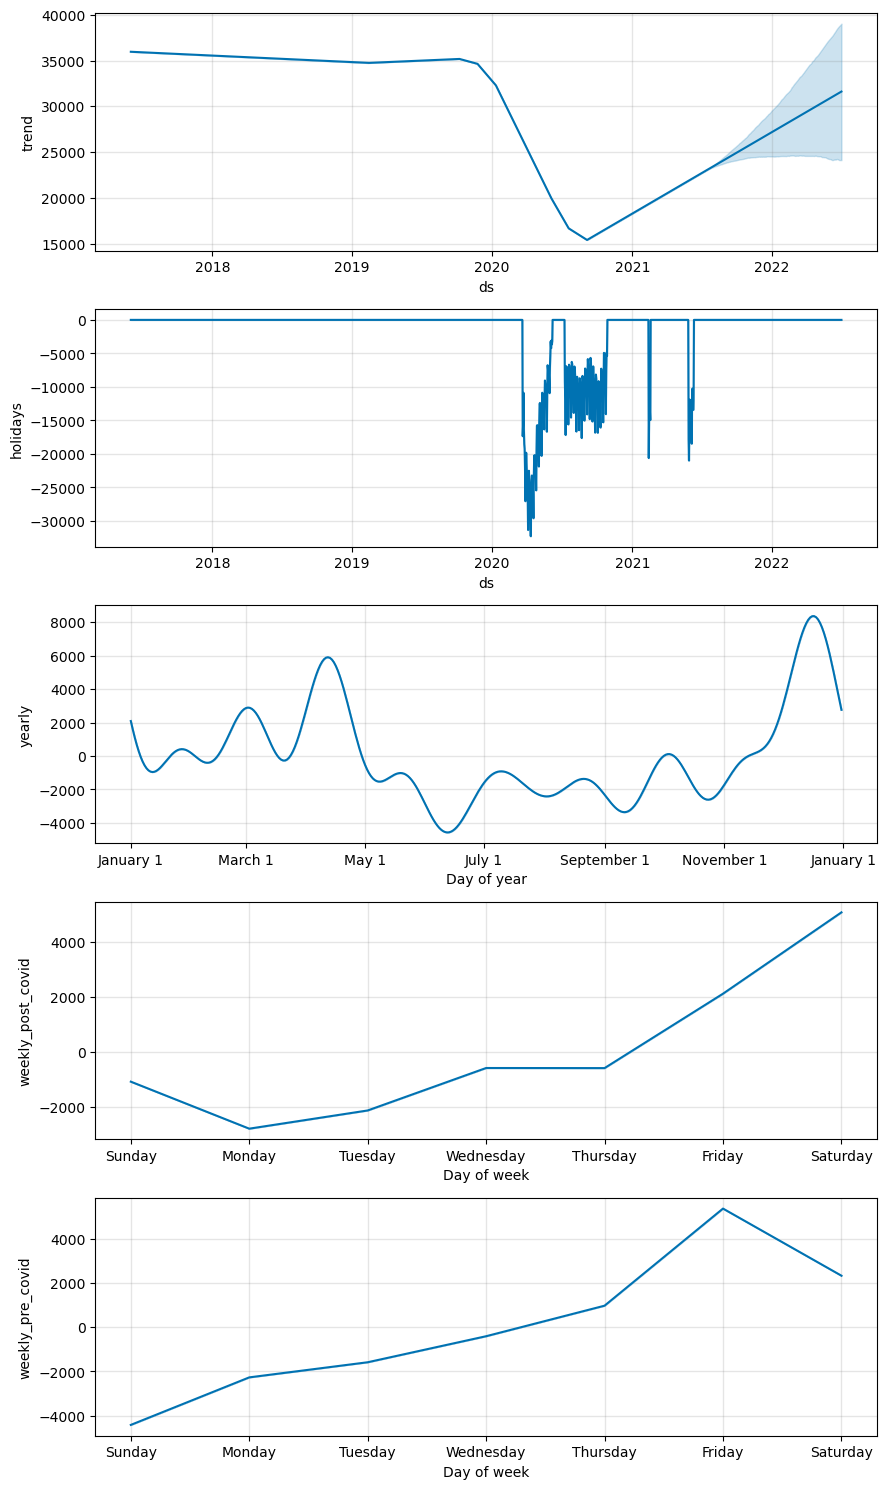

In [28]:
m4.plot_components(forecast4)

Thật thú vị, mô hình với tính thời vụ có điều kiện gợi ý rằng, sau COVID, hoạt động của người đi bộ đạt đỉnh điểm vào Thứ Bảy, thay vì Thứ Sáu. Điều này có thể hợp lý nếu hầu hết mọi người vẫn đang làm việc tại nhà và do đó ít có khả năng ra ngoài vào tối thứ Sáu. Từ góc độ dự đoán, điều này sẽ chỉ quan trọng nếu chúng ta quan tâm đến việc dự đoán chính xác các ngày trong tuần so với cuối tuần, nhưng nhìn chung, loại khám phá này giúp chúng ta hiểu rõ hơn về cách COVID đã thay đổi hành vi.

## Further reading (đọc thêm)

Rất nhiều nội dung trong trang này được lấy cảm hứng từ [cuộc thảo luận GitHub này](https://github.com/facebook/prophet/issues/1416). Chúng tôi đã đề cập đến một số kết quả treo thấp để điều chỉnh các mô hình Prophet khi đối mặt với những cú sốc như COVID, nhưng cũng có nhiều cách tiếp cận khả thi khác, chẳng hạn như:

- Sử dụng các biến hồi quy bên ngoài (ví dụ: chỉ số nghiêm ngặt lockdown). Điều này sẽ chỉ hiệu quả nếu chúng tôi a) có dữ liệu biến hồi quy phù hợp tốt (về vị trí) với chuỗi mà chúng tôi dự báo và b) có quyền kiểm soát hoặc có thể dự đoán biến hồi quy chính xác hơn nhiều so với chỉ chuỗi thời gian.
- Phát hiện và loại bỏ dữ liệu ngoại lệ khỏi giai đoạn đào tạo hoặc loại bỏ hoàn toàn dữ liệu đào tạo cũ hơn. Đây có thể là cách tiếp cận tốt hơn cho chuỗi thời gian phụ hàng ngày không có mẫu theo mùa hàng năm.

Mặc dù nhìn chung, thật khó để tin tưởng vào dự báo của chúng tôi trong những môi trường này khi các quy tắc liên tục thay đổi và các đợt bùng phát xảy ra ngẫu nhiên. Trong trường hợp này, điều quan trọng hơn là phải liên tục đào tạo lại/đánh giá lại các mô hình của chúng tôi và thông báo rõ ràng về sự không chắc chắn gia tăng trong các dự báo.
